In [1]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# RUN THIS COMMAND ONLY IF YOU USE GOOGLE COLAB.
#%cd drive/MyDrive/commfy

# Multiclass Classifier to Predict Feet Items 
The objective of this notebook is to build a machine learning model that predicts feet items (shoe & sock combination) by leveraging random forest classifier.

## 1. Importing required modules and loading data file
In the first section of this notebook, we have to import all neccessary libraries, required modules and essential packages. After running them in this cell, we will be able to use them in subsequent cells throughout the notebook.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for displaying plots
import seaborn as sns; sns.set() # plotting package for histograms
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from matplotlib import cm #for creating color maps

In [59]:
#skipping some rows and reading only relevant parts into dataframe
feets = pd.read_csv('input_data.csv', skiprows=2) 
#starting index from 1 in dataframe
feets.index = feets.index + 1 

## 2. Exploratory data analysis (EDA) and data cleaning
In this section, it is essential to conduct the initial investigations on data to discover the patterns, identify outliers and spot noises with the help of summary statistics and graphical representations. The goal of EDA is to summarize the important characteristics of data in order to gain better understanding of the dataset and prepare data for machine learning.

### The first step in EDA is to get familiar with dataset
After importing the dataset, we get a quick glance at a data and check the shape of a dataset.

In [60]:
#see the first view of a dataset & check if data has been read into a dataframe object
feets.head()

,Unnamed: 0,a,b,c,d,e,f
1,0,23.633087,1.0,cloudy,1.0,1.0,-2
2,1,38.742237,1.0,sunny,0.0,1.0,0
3,2,NaN,1.0,sunny,1.0,2.0,2
4,3,22.249957,1.0,sunny,0.0,1.0,-5
5,4,27.007875,1.0,cloudy,0.0,0.0,-2


In [61]:
#renaming the columns with self-explanatory titles
feets.rename({"a": "temperature", "b": "feet_class", "c": "weather","d": "sex", "e":"heaviness_trip", "f":"heat_perception"},axis = 1, inplace = True)

In [62]:
#slicing out the unneccesary column
feets = feets.iloc[: , 1:] 

In [63]:
feets.isnull().sum(axis=0)

temperature        4
feet_class         2
weather            2
sex                1
heaviness_trip     4
heat_perception    0
dtype: int64

since there are very little nan Values we decided to drop the rows with nan Values, cause it is not statistic significant.

In [64]:
#drop rows with NaN values
feets.dropna(inplace = True)

In [65]:
#find out the columns & their corresponding data types
feets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24988 entries, 1 to 25000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperature      24988 non-null  float64
 1   feet_class       24988 non-null  float64
 2   weather          24988 non-null  object 
 3   sex              24988 non-null  float64
 4   heaviness_trip   24988 non-null  float64
 5   heat_perception  24988 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.3+ MB


In [8]:
#converting feet_class, sex and heaviness_trip from float to int
feets = feets.astype({"feet_class":'int', "sex":'int', "heaviness_trip": 'int'}) 
display(feets.dtypes)

temperature        float64
feet_class           int32
weather             object
sex                  int32
heaviness_trip       int32
heat_perception      int64
dtype: object

In [9]:
feets['heat_perception'].unique()
feets['heat_perception'].replace([44],[4], inplace=True)

In [10]:
#getting unique values of the weather series object to spot the typos of the values
feets['weather'].unique()

array(['cloudy', 'sunny', 'sunnny', 'cloudi', 'Sunny', 'snowy', 'rainy',
       'rayny', 'raiiny'], dtype=object)

In [11]:
#harmonising values in weather state column with df.replace()
feets.replace(['cloudi', 'sunnny','Sunny', 'rayny','raiiny'], ['cloudy', 'sunny', 'sunny', 'rainy','rainy'],inplace=True)

In [12]:
#check if the changes have been placed
feets['weather'].unique()

array(['cloudy', 'sunny', 'snowy', 'rainy'], dtype=object)

In [13]:
feets.head(20)

,temperature,feet_class,weather,sex,heaviness_trip,heat_perception
1,23.633087,1,cloudy,1,1,-2
2,38.742237,1,sunny,0,1,0
4,22.249957,1,sunny,0,1,-5
5,27.007875,1,cloudy,0,0,-2
6,37.733175,1,sunny,1,1,0
8,29.576284,1,cloudy,0,0,2
9,20.621831,1,cloudy,0,0,0
10,26.420650,1,cloudy,1,2,4
11,32.254068,1,sunny,0,0,4
12,23.861613,1,sunny,0,0,-4


### The third step is to conduct descriptive statistics of a datatset.
We call the describe() function to gain insights into the shape of each attribute by creating summary statistics by viewing central tendency, mean, median, standard deviation, percentile and max values.

In [14]:
feets.describe() #for the statistical summary of numerical data

,temperature,feet_class,sex,heaviness_trip,heat_perception
count,24988.000000,24988.000000,24988.000000,24988.000000,24988.000000
mean,9.206686,3.000000,0.529974,0.999920,0.024652
std,15.723573,1.414242,0.537636,0.816497,3.170801
min,-17.192980,1.000000,0.000000,0.000000,-5.000000
25%,-5.509675,2.000000,0.000000,0.000000,-3.000000
50%,5.538684,3.000000,1.000000,1.000000,0.000000
75%,24.473846,4.000000,1.000000,2.000000,3.000000
max,55.272944,5.000000,2.000000,2.000000,5.000000


### The fourth step is to create a bar chart.
Plotting the bar chart will show the class distribution of the independent variables (x axis distinct items, y axis frequency). 

In [16]:
#bar chart

### This fifth step is to plot histograms/kernel density plots for each variables. 
This visualization technique will enable us to see how frequently data in each class occur in the dataset. Namely, it will graphically show the frequency of different data points in the dataset, location of the center of data, the spread of dataset, skewness of dataset and presence of outliers.

Text(0.5, 1.0, 'Histogram of temperature')

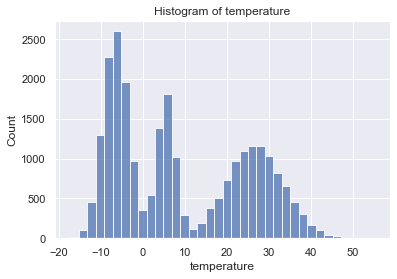

In [17]:
#histograms - for quantitative data
sns.histplot(feets["temperature"], kde = False).set_title("Histogram of temperature")
#kde - by default always includes are density plot. if it visually distracts, you can set the parameter kde into false.        


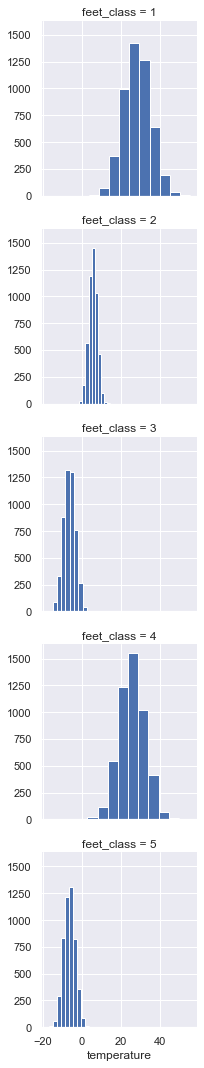

In [18]:
g = sns.FacetGrid(feets, row = "feet_class")
g = g.map(plt.hist, "temperature")
plt.show()

In [19]:
#g = sns.FacetGrid(feets, row ='temperature')
#g.map(plt.hist, 'value')
#plt.show()
#build multiplot grids based on above example

<AxesSubplot:title={'center':'temperature'}, xlabel='feet_class'>

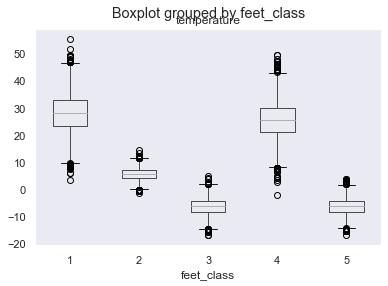

In [20]:
feets.boxplot(by ='feet_class', column =['temperature'], grid = False)

### The last step of this section checks the correlation between features in a dataset by calling df.corr()

 
 It calculates the correlation between features pairwise excluding null values. Thus, we will gain understanding on one or multiple attributes that might be dependent on another attribute or a cause for another attribute.Feature correlations matter in predicting one attribute from another.

The cell computes a correlation matrix (Max's note: be mindful of the type of correlation and the scale level of the variable, pearson vs. spearman correlation)

In [17]:
feets.corr()# to reveal whether correlation is positive, negative
#or non-existent. 
#Read more on correlation matrix to interpret Max's note above. 

,temperature,feet_class,sex,heaviness_trip,heat_perception
temperature,1.000000,-0.441527,0.033668,0.032112,0.077897
feet_class,-0.441527,1.000000,0.004790,0.004610,0.002544
sex,0.033668,0.004790,1.000000,0.804565,0.010248
heaviness_trip,0.032112,0.004610,0.804565,1.000000,0.003850
heat_perception,0.077897,0.002544,0.010248,0.003850,1.000000



## 3. Data pre-processing
In this section we will preapre machine learning data by splitting data to three datatsets: train-set, validation- and test-sets. The third set is important to test the final performance of the model. It is used only  on the fine-tuned model. Once it is used, it loses its "value".

### In the first of this section, we will create machine learning datatsets.

Create a train/validation/test split (e.g., 50%, 25%, 25% according to Hastie et al. (2009, p. 222).

In [15]:
# for our model we use such output data as temperature, sex, heat perception and weather state
X = feets[['temperature', 'sex', 'heat_perception','heaviness_trip']]
y = feets['feet_class']

# default is 75% / 25% train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## 4. Model training
In this section, we will feed the ML algorithms with data to help identify and learn good values for all attributed involved. 

### Dummy Classifiers
DummyClassifier is a classifier that makes predictions using simple rules, which can be useful as a baseline for comparison against actual classifiers, especially with imbalanced classes.

In [19]:
# Negative class (0) is most frequent
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
# Therefore the dummy 'most_frequent' classifier always predicts class 0
y_dummy_predictions = dummy_majority.predict(X_test)

y_dummy_predictions

array([4, 4, 4, ..., 4, 4, 4])

### K-Nearest Neighbours Classification

In [66]:
knn = KNeighborsClassifier(n_neighbors = 32)

In [67]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=32)

In [21]:
knn.score(X_test, y_test)

0.6291019689450936

we are training the k-nn algorithm and give out the accuracy for each k value from 1-100

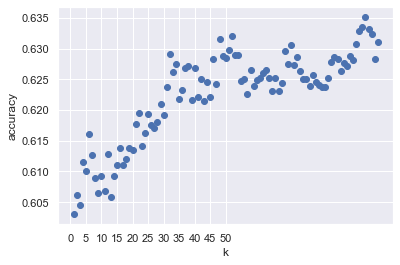

In [68]:
k_range = range(1,100)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50]);

In [31]:
#alter the following code to meet our needs

plot_two_class_knn(X_train, y_train, 1, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 3, 'uniform', X_test, y_test)
plot_two_class_knn(X_train, y_train, 11, 'uniform', X_test, y_test)

NameError: name 'plot_two_class_knn' is not defined

### Random Forest Classifier
Adapt the following example code from Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001. For documentation click [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [56]:
X, y = make_classification(n_features=4)
clf =RandomForestClassifier(n_estimators=100)
clf.fit(X, y)
print(clf.score(X_test, y_test))

0.1989755082439571


### Decision Tree: 
for comparing ruledbasedmodel with the decision tree for feet

### Rule-based algorithm 
The rule-based model file will be incorporated here once it is finalized.

## 5. Model evaluation 
#### (more research is needed to define the relevant metrics)
In this step we will use corresponding metrics to test the ability of multi-class classifier by comparing the performance of different models and eventually, analysing the best peforming model my tuning different parameters.

### Use the trained classifier model to classify new objects

In [ ]:
#new object classification on the "test set" as defined by Hastie et al. above

### Accuracy
This metric will be directly computed from the confusion matrix. <p> Is already Featured in training the model

### Multi-class confusion matrix
Confusion Matrix is used to know the performance of a Machine learning classification. It is represented in a matrix form. [Confusion Matrix](https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/#:~:text=Confusion%20Matrix%20is%20used%20to,between%20Actual%20and%20predicted%20values.&text=Confusion%20Matrix%20has%204%20terms,and%20False%20Negative(FN).) gives a comparison between Actual and predicted values

In [ ]:
#some code

### Precision and recall
Precision quantifies the number of positive class predictions that actually belong to the positive class. Recall quantifies the number of positive class predictions made out of all positive examples in the dataset. [For more read the following blog](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2).

In [ ]:
#some code

### K-fold cross-validation
In this step, we will leverage k-fold cross validation  to estimate the skill of the model on new data.

In [ ]:
#some code


## 6. Model deployment

ML learning part is not getting deployed in the app

Further steps: save the model as a file, and create an .xls file with the testset (as defined by Hastie et al., 2009) and corresponding predictions in an additional column Details to be aligned with WD team (e.g., Flask interface).